* reference  
https://hub.packtpub.com/predicting-sports-winners-decision-trees-and-pandas/  
https://github.com/chandanverma07/Ebooks/blob/master/Learning%20Data%20Mining%20with%20Python.pdf
 chapter3 p.41~ 

# Predicting Sports Winners with Decision Trees

In this chapter, we will look at predicting the winner of games of the National Basketball Association (NBA).   
Matches in the NBA are often close and can be decided in the last minute, making predicting the winner quite difficult.


Using the 2013-2014 NBA dataset and decision trees model, let's predict the winner of the game.

Data is available here https://www.basketball-reference.com/leagues/NBA_2014_games-november.html

## Using pandas to load the dataset

In [1]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt

dataset = pd.read_csv('./NBA_nov.csv')

In [2]:
print(dataset.shape)

(228, 10)


In [3]:
dataset.loc[:2]

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes
0,Fri Nov 1 2013,7:00p,Cleveland Cavaliers,84,Charlotte Bobcats,90,Box Score,NaN,18017,NaN
1,Fri Nov 1 2013,7:00p,New Orleans Pelicans,90,Orlando Magic,110,Box Score,NaN,18846,NaN
2,Fri Nov 1 2013,7:00p,Philadelphia 76ers,109,Washington Wizards,102,Box Score,NaN,17160,NaN


the dataframe headings aren't complete.
Rename the column to make it easier to see.

The order is Date, Start (ET), Visitor/Neutral, visitorPTS, Home team, homePTS, Score type, OT?, Attend, Notes.

In [4]:
dataset.rename(columns={'PTS': 'visitorPTS', 'PTS.1': 'homePTS', 'Unnamed: 6':'Score type', 'Unnamed: 7':'OT?','Attend.':'Attend', 'Visitor/Neutral':'Visitor team', 'Home/Neutral':'Home team'}, inplace=True)

In [5]:
dataset.loc[:2]

,Date,Start (ET),Visitor team,visitorPTS,Home team,homePTS,Score type,OT?,Attend,Notes
0,Fri Nov 1 2013,7:00p,Cleveland Cavaliers,84,Charlotte Bobcats,90,Box Score,NaN,18017,NaN
1,Fri Nov 1 2013,7:00p,New Orleans Pelicans,90,Orlando Magic,110,Box Score,NaN,18846,NaN
2,Fri Nov 1 2013,7:00p,Philadelphia 76ers,109,Washington Wizards,102,Box Score,NaN,17160,NaN


## Extracting new features

We can now extract our features from this dataset by combining and comparing the existing data. First up, we need to specify our class value, which will give our classification algorithm something to compare against to see if its prediction is correct or not.    
for this application, we will specify our class as 1 if the home team wins and 0 if the visitor team wins.

In [6]:
dataset["HomeWin"] = dataset["visitorPTS"] < dataset["homePTS"]

In [7]:
y_true = dataset["HomeWin"].values

In [8]:
y_true[:10]

array([ True,  True, False,  True, False,  True,  True,  True,  True,
       False])

In [9]:
y_true.shape

(228,)

The first two features we want to create to help us predict which team will win
are whether either of those two teams won their last game. This would roughly
approximate which team is playing well.

We will compute this feature by iterating through the rows in order and recording
which team won. When we get to a new row, we look up whether the team won the
last time we saw them

In [10]:
# We first create a (default) dictionary to store the team's last result:
from collections import defaultdict
won_last = defaultdict(int)

In [11]:
dataset2 = pd.DataFrame()
for index, row in dataset.iterrows():  
    home_team = row["Home team"]  
    visitor_team = row["Visitor team"] 
    row["HomeLastWin"] = won_last[home_team] 
    row["VisitorLastWin"] = won_last[visitor_team]
    won_last[home_team] = row["HomeWin"]
    won_last[visitor_team] = not row["HomeWin"]
    dataset.iloc[index] = row
    dataset2 = dataset2.append(row)

In [12]:
dataset2 = dataset2[['Date', 'Start (ET)', 'Visitor team', 'visitorPTS', 'Home team', 'homePTS','HomeWin','HomeLastWin','VisitorLastWin', 'Score type', 'OT?', 'Attend', 'Notes']]

In [14]:
dataset2.tail(3)

,Date,Start (ET),Visitor team,visitorPTS,Home team,homePTS,HomeWin,HomeLastWin,VisitorLastWin,Score type,OT?,Attend,Notes
225,Sat Nov 30 2013,8:30p,Houston Rockets,112.0,San Antonio Spurs,106.0,0.0,1.0,1.0,Box Score,NaN,18581.0,NaN
226,Sat Nov 30 2013,9:00p,Boston Celtics,85.0,Milwaukee Bucks,92.0,1.0,0.0,1.0,Box Score,NaN,15471.0,NaN
227,Sat Nov 30 2013,9:00p,Utah Jazz,112.0,Phoenix Suns,104.0,0.0,1.0,0.0,Box Score,NaN,12957.0,NaN


## Decision trees

Decision trees are a class of supervised learning algorithm like a flow chart that
consists of a sequence of nodes, where the values for a sample are used to make a
decision on the next node to go to.

1) ["HomeLastWin", "VisitorLastWin"]

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [16]:
clf = DecisionTreeClassifier(random_state=14)

In [17]:
X_previouswins = dataset2[["HomeLastWin", "VisitorLastWin"]].values

In [18]:
X_previouswins.shape

(228, 2)

In [19]:
X_previouswins[-1]

array([1., 0.])

We can use the cross_val_score method to get the average score:

In [20]:
scores = cross_val_score(clf, X_previouswins, y_true, scoring='accuracy')
print("Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

Accuracy: 62.3%


We can also use fit and predict methods.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_previouswins, y_true, test_size=0.3, random_state=0)

In [22]:
clf2 = clf.fit(X_train, y_train)

In [23]:
pred = clf2.predict(X_test)

In [24]:
X_test[0]

array([1., 0.])

In [25]:
conf_matrix = pd.crosstab(y_test, pred)
print(conf_matrix)

col_0  False  True 
row_0              
False      7     18
True      11     33


In [26]:
scores1 = clf2.score(X_train, y_train)
print('Train score : ', round(scores1*100, 1),'%')
scores2 = clf2.score(X_test, y_test)
print('Test score : ', round(scores2*100, 1),'%')

Train score :  64.2 %
Test score :  58.0 %


In [27]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
dot_data = export_graphviz(clf2, out_file=None, feature_names=['HomeLastWin', 'VisitorLastWin'],
                           filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
img = Image(graph.create_png())

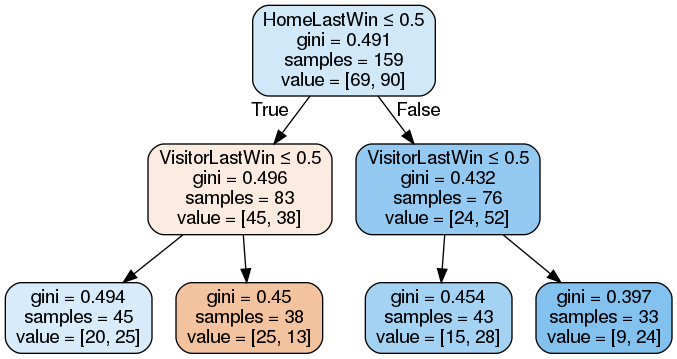

In [28]:
img

## Sports outcome prediction

There are many possible features we could use, but we will try the following questions:  
* Which team is considered better generally?
*  Which team won their last encounter?

For the first feature, we will create a feature that tells us if the home team is generally
better than the visitors. To do this, we will load the standings (also called a ladder in
some sports) from the NBA in the previous season. A team will be considered better
if it ranked higher in 2013 than the other team.

https://www.basketball-reference.com/leagues/NBA_2013_standings.html

2) [“HomeLastWin”, “VisitorLastWin”, “HomeTeamRanksHigher”]

In [29]:
data_folder = './'

In [30]:
standings_filename = os.path.join(data_folder, "NBA_standings.csv")
standings = pd.read_csv(standings_filename)

In [31]:
standings.head(2)

,Rk,Team,Overall,Home,Road,E,W,A,C,SE,...,Post,≤3,≥10,Oct,Nov,Dec,Jan,Feb,Mar,Apr
0,1,Miami Heat,66-16,37-4,29-12,41-11,25-5,14-4,12-6,15-1,...,30-2,9-3,39-8,1-0,10-3,10-5,8-5,12-1,17-1,8-1
1,2,Oklahoma City Thunder,60-22,34-7,26-15,21-9,39-13,7-3,8-2,6-4,...,21-8,3-6,44-6,NaN,13-4,11-2,11-5,7-4,12-5,6-2


As an important adjustment to the data, a team was renamed between the 2013 and
2014 seasons (but it was still the same team). We will need to adjust.

In [32]:
dataset2["HomeTeamRanksHigher"] = 0

dataset3 = pd.DataFrame()
for index, row in dataset2.iterrows():
    home_team = row["Home team"]
    visitor_team = row["Visitor team"]
    if home_team == "New Orleans Pelicans":
        home_team = "New Orleans Hornets"
    elif visitor_team == "New Orleans Pelicans":
        visitor_team = "New Orleans Hornets"
    home_rank = standings[standings["Team"] == home_team]["Rk"].values[0]
    visitor_rank = standings[standings["Team"] == visitor_team]["Rk"].values[0]
    row["HomeTeamRanksHigher"] = int(home_rank > visitor_rank)
    dataset2.iloc[index] = row
    dataset3 = dataset3.append(row)

In [33]:
dataset3 = dataset3[['Date', 'Start (ET)', 'Visitor team', 'visitorPTS', 'Home team', 'homePTS','HomeWin','HomeLastWin','VisitorLastWin', 'HomeTeamRanksHigher','Score type', 'OT?', 'Attend', 'Notes']]

In [34]:
dataset3.head(2)

,Date,Start (ET),Visitor team,visitorPTS,Home team,homePTS,HomeWin,HomeLastWin,VisitorLastWin,HomeTeamRanksHigher,Score type,OT?,Attend,Notes
0,Fri Nov 1 2013,7:00p,Cleveland Cavaliers,84.0,Charlotte Bobcats,90.0,1.0,0.0,0.0,1.0,Box Score,NaN,18017.0,NaN
1,Fri Nov 1 2013,7:00p,New Orleans Pelicans,90.0,Orlando Magic,110.0,1.0,0.0,0.0,1.0,Box Score,NaN,18846.0,NaN


In [35]:
# dataset3.tail(2)

In [36]:
X_homehigher = dataset3[["HomeLastWin", "VisitorLastWin", "HomeTeamRanksHigher"]].values

In [37]:
clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf, X_homehigher, y_true, scoring='accuracy')
print("Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

Accuracy: 58.8%


Next, let's test which of the two teams won their last match.

3) [“HomeTeamRanksHigher”, “HomeTeamWonLast”]

In [38]:
last_match_winner = defaultdict(int)
dataset3["HomeTeamWonLast"] = 0

In [39]:
dataset4 = pd.DataFrame()
for index, row in dataset3.iterrows():
    home_team = row["Home team"]
    visitor_team = row["Visitor team"]
    teams = tuple(sorted([home_team, visitor_team]))
    row["HomeTeamWonLast"] = 1 if last_match_winner[teams] == row["Home team"] else 0
    winner = row["Home team"] if row["HomeWin"] else row ["Visitor team"]
    last_match_winner[teams] = winner
    dataset4 = dataset4.append(row)

In [40]:
#last_match_winner

In [41]:
dataset4 = dataset4[['Date', 'Start (ET)', 'Visitor team', 'visitorPTS', 'Home team', 'homePTS','HomeWin','HomeLastWin','VisitorLastWin', 'HomeTeamRanksHigher','HomeTeamWonLast','Score type', 'OT?', 'Attend', 'Notes']]

In [42]:
dataset4.head(2)

,Date,Start (ET),Visitor team,visitorPTS,Home team,homePTS,HomeWin,HomeLastWin,VisitorLastWin,HomeTeamRanksHigher,HomeTeamWonLast,Score type,OT?,Attend,Notes
0,Fri Nov 1 2013,7:00p,Cleveland Cavaliers,84.0,Charlotte Bobcats,90.0,1.0,0.0,0.0,1.0,0.0,Box Score,NaN,18017.0,NaN
1,Fri Nov 1 2013,7:00p,New Orleans Pelicans,90.0,Orlando Magic,110.0,1.0,0.0,0.0,1.0,0.0,Box Score,NaN,18846.0,NaN


In [43]:
X_lastwinner = dataset4[["HomeTeamRanksHigher", "HomeTeamWonLast"]].values
clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf, X_lastwinner, y_true, scoring='accuracy')
print("Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

Accuracy: 56.1%


4) ["HomeLastWin", "VisitorLastWin“, “HomeLastWin”, “VisitorLastWin”, “HomeTeamRanksHigher”] 

In [62]:
from sklearn.model_selection import train_test_split
X_lastwinner = dataset4[["HomeLastWin", "VisitorLastWin", "HomeTeamRanksHigher", "HomeTeamWonLast", "HomeTeamRanksHigher"]].values
clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf, X_lastwinner, y_true, scoring='accuracy')
print("Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

Accuracy: 61.0%


In [60]:
X_train, X_test, y_train, y_test=train_test_split(X_lastwinner, y_true, test_size=0.3, random_state=0)
clf2 = clf.fit(X_train, y_train)

In [61]:
scores2 = clf2.score(X_test, y_test)
print('Test score : ', round(scores2*100, 1),'%')

Test score :  55.1 %


In [47]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
dot_data = export_graphviz(clf2, out_file=None, feature_names=['HomeLastWin', 'VisitorLastWin',"HomeTeamRanksHigher", "HomeTeamWonLast", "HomeTeamRanksHigher"],
                           filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
img = Image(graph.create_png())

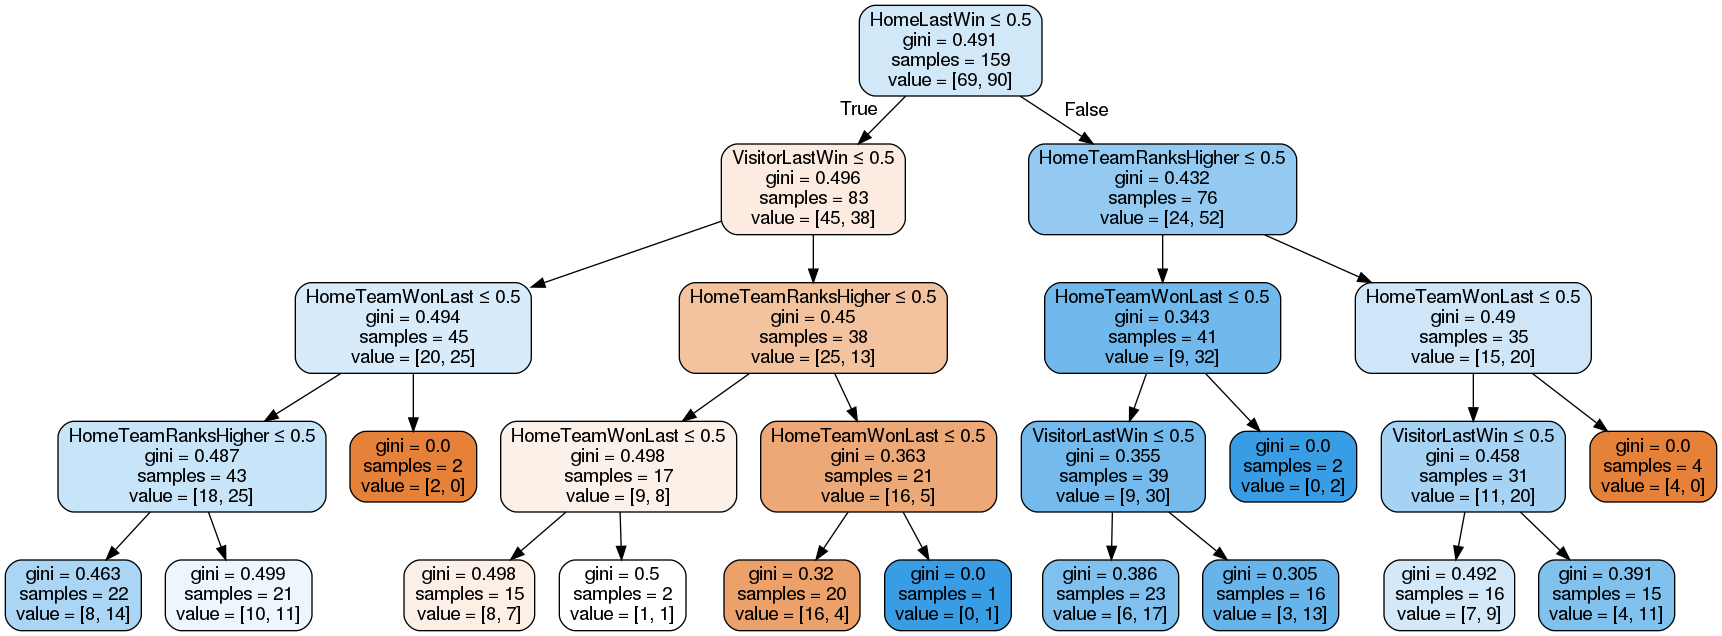

In [48]:
img

We will also try putting the raw teams into the algorithm to check whether the
algorithm can learn a model that checks how different teams play against each other

5) [“Home team”, "Visitor team”] 

In [49]:
from sklearn.preprocessing import LabelEncoder
encoding = LabelEncoder()

In [50]:
encoding.fit(dataset4["Home team"].values)

LabelEncoder()

In [51]:
home_teams = encoding.transform(dataset4["Home team"].values)
visitor_teams = encoding.transform(dataset4["Visitor team"].values)
X_teams = np.vstack([home_teams, visitor_teams]).T

In [52]:
print(home_teams[:5])  
print(X_teams.shape)

[ 3 21 29  0  1]
(228, 2)


In [53]:
X_teams[0]

array([3, 5])

In [54]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()

In [55]:
X_teams_expanded = onehot.fit_transform(X_teams).todense()

In [56]:
X_teams_expanded[0]  

matrix([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [57]:
X_teams_expanded.shape

(228, 60)

In [58]:
clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf, X_teams_expanded, y_true,scoring='accuracy')
print("Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

Accuracy: 60.1%


* model accurady by feature

["HomeLastWin", "VisitorLastWin"]  62.3%  
["HomeLastWin", "VisitorLastWin", "HomeTeamRanksHigher"] 58.8%,  
["HomeTeamRanksHigher", "HomeTeamWonLast"]] 56.1%  
["HomeLastWin", "VisitorLastWin“, “HomeLastWin”, “VisitorLastWin”, “HomeTeamRanksHigher”] 61.0%  
["Home team", "Visitor teamk] 60.1%.